In [1]:
import sys
sys.path.append('./../')

import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)

from datasets.dataset import _load_collection_real,_load_collection_syn
from models_utility.construct_models import _initialize_SMkernelhyp,_make_gpmodel
from models_utility.param_gp import Param



from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt



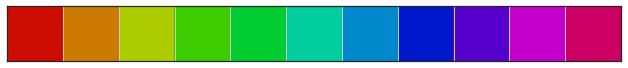

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')



plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
import scipy.io as sio

def _load_syn(filename,cuda_option):
    device = torch.device('cuda:0' if cuda_option else 'cpu')    
    Dataset = sio.loadmat('./datasets/synthetic/' + filename + '.mat')
    x_train, x_test, y_train, y_test , x_full, y_full = Dataset['x_train'], Dataset['x_test'],Dataset['y_train'], Dataset['y_test'],Dataset['x_full'], Dataset['y_full']
    x_train, x_test, y_train, y_test, x_full,y_full = np.float64(x_train), np.float64(x_test) , np.float64(y_train), np.float64(y_test), np.float64(x_full), np.float64(y_full)
    return torch.from_numpy(x_train).to(device),torch.from_numpy(x_test).to(device),torch.from_numpy(x_full).to(device),\
           torch.from_numpy(y_train).to(device),torch.from_numpy(y_test).to(device),torch.from_numpy(y_full).to(device),Dataset


In [4]:
random_seed = 1000
device = True

filename = 'SM_Q2_exp1'
x_train, x_test, x_full, y_train, y_test,y_full,Dataset = _load_syn(filename, cuda_option=device)




In [7]:
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 500
setting_dict['input_dim'] = 1

setting_dict['num_Q'] = 2
setting_dict['num_sample_pt'] = 10
setting_dict['num_batch'] = 1

setting_dict['lr_hyp'] = 0.01        

setting_dict['kl_option'] = True   
setting_dict['iter'] = 6000       
setting_dict['num_rep'] = 1
setting_dict['weight_rate'] = 0.1  
setting_dict['noise_err'] = 0.005*y_train.std()



setting_dict = _initialize_SMkernelhyp( x_train,y_train, setting_dict, random_seed)


In [8]:
#ith_model_name = 'equal_reg'
ith_model_name = 'weight_reg'
model = _make_gpmodel(model_name=ith_model_name, setting_dict=setting_dict, device=device)
model._set_data(x_train,y_train)

total spt:20, spt:10, Q:2 in spt manager
total spt:20, spt:10, Q:2 in spt manager
total spt:20, spt:10, Q:2 in setup model 


In [9]:
optimizable_param =  [*model.parameters(),model.likelihood.variance]
optimizable_param

[sf2 : tensor([0.], device='cuda:0', dtype=torch.float64),
 weight : tensor([[0.],
         [0.]], device='cuda:0', dtype=torch.float64),
 std : tensor([[-0.9912],
         [ 2.8183]], device='cuda:0', dtype=torch.float64),
 mu : tensor([[-0.4389],
         [ 3.1371]], device='cuda:0', dtype=torch.float64),
 std_prior : tensor([[-3.3422],
         [-6.1309]], device='cuda:0', dtype=torch.float64),
 mu_prior : tensor([[-2.2000],
         [-2.4192]], device='cuda:0', dtype=torch.float64),
 noise_variance : tensor([-5.4225], device='cuda:0', dtype=torch.float64)]

In [10]:
optimizer = torch.optim.Adam(optimizable_param ,
                               lr=setting_dict['lr_hyp'],
                               betas=(0.9, 0.99),
                               eps=1e-08,
                               weight_decay=0.0)

In [11]:
observe_period = 100

In [12]:
for i in range(setting_dict['iter'] + 1):
    ith_tic = time.time()    
    optimizer.zero_grad()    
    ith_loss = model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])        
    ith_loss.backward()
    optimizer.step()

    
    
    with torch.no_grad():
        pred_train_mu, pred_train_var = model._predict(inputs_new=x_train)
        pred_test_mu, pred_test_var = model._predict(inputs_new=x_test)

    # out1 : root mean square (rmse)
    # out2 : mean negative log likelihood (mnll)
    ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)

    if i % observe_period == 0 :
        print('%d th loss0 : %.4f, test rmse : %.4f, test mnll: : %.4f' % (i,ith_loss.cpu().data.numpy(),ith_rmse,ith_mnll))
        try:
            print('self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance')            
            print(model.weight.exp().squeeze(),model.mu.exp().squeeze(),model.std.exp().squeeze(),model.likelihood.variance.transform()**2)

            print('\n')
            print('self.num_samplept_list_at')
            print(model.num_samplept_list_at)
        except:
            pass
        
        print('')

    
    




0 th loss0 : 97269309.0256, test rmse : 0.8375, test mnll: : 16791.1269
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.0101, 0.9900], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([ 0.6512, 22.8077], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([ 0.3749, 16.5819], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([1.9897e-05], device='cuda:0', dtype=torch.float64,
       grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

100 th loss0 : 49804101.0810, test rmse : 1.2348, test mnll: : 9052.6651
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.2180, 0.8223], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([ 0.6799, 17.2206], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([ 0.3033, 12.2949], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0

1500 th loss0 : 163173.8673, test rmse : 0.7536, test mnll: : 2.8944
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([7.9517, 3.5828], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.7576, 0.9300], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.3337, 0.8872], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0802], device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>)


self.num_samplept_list_at
[10, 10]

1600 th loss0 : 99474.6214, test rmse : 0.6853, test mnll: : 1.6272
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([9.2748, 4.8425], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.7499, 0.7394], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.3382, 0.6997], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.1015], device=

3000 th loss0 : -760.8161, test rmse : 0.2101, test mnll: : 0.2907
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([107.4307, 542.2937], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.8802, 0.1273], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.1087, 0.0417], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0117], device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>)


self.num_samplept_list_at
[11, 9]

3100 th loss0 : -206.1674, test rmse : 0.3482, test mnll: : 2.5355
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([109.8184, 757.9790], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.9292, 0.1249], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0990, 0.0399], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0107], dev

4500 th loss0 : -856.4109, test rmse : 0.2165, test mnll: : 0.6777
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.6482e+01, 3.7697e+04], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.9023, 0.1137], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0281, 0.0327], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0096], device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>)


self.num_samplept_list_at
[9, 11]

4600 th loss0 : -946.9567, test rmse : 0.2140, test mnll: : 0.8045
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([1.2729e+01, 4.9171e+04], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.8831, 0.1155], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0266, 0.0324], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.00

6000 th loss0 : -1001.2461, test rmse : 0.3332, test mnll: : 3.9475
self.weight.exp(),self.mu.exp(),self.std.exp(),likelihood variance
tensor([3.2186e+00, 1.2113e+07], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.8836, 0.1040], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0213, 0.0260], device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>) tensor([0.0090], device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>)


self.num_samplept_list_at
[9, 11]



# approximate prediction 
## SM kernel Recovery test

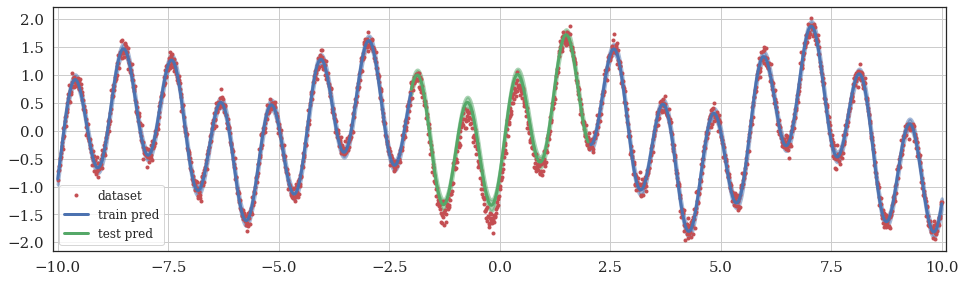

(array(0.2029), array(0.567))

In [13]:
x_train_l = x_train[x_train <= 0].view(-1,1)
x_train_r = x_train[x_train > 0].view(-1,1)
y_train_l = y_train[x_train <= 0].view(-1,1)
y_train_r = y_train[x_train > 0].view(-1,1)


with torch.no_grad():
    pred_train_mu_l, pred_train_var_l = model._predict(inputs_new=x_train_l)
    pred_train_mu_r, pred_train_var_r = model._predict(inputs_new=x_train_r)
    
    pred_test_mu, pred_test_var = model._predict(inputs_new = x_test, diag=True)    
        

plt.figure(figsize=(16,4.5))
plt.plot(x_train_l.cpu().data.numpy(),y_train_l.cpu().data.numpy(),'r.',label = 'dataset')    
plt.plot(x_train_l.cpu().data.numpy(),pred_train_mu_l.cpu().data.numpy(),'b',linewidth = 3,label = 'train pred')
plt.fill_between( x_train_l.cpu().data.numpy().squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)

plt.plot(x_train_r.cpu().data.numpy(),y_train_r.cpu().data.numpy(),'r.')    
plt.plot(x_train_r.cpu().data.numpy(),pred_train_mu_r.cpu().data.numpy(),'b',linewidth = 3)
plt.fill_between( x_train_r.cpu().data.numpy().squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)


plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'g',linewidth = 3,label = 'test pred')
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'g', facecolor = 'g',linewidth = 3)


plt.xlim([-10-.1,10+.1])    
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

_evaluate_metric(pred_train_mu, pred_train_var, y_train)
_evaluate_metric(pred_test_mu, pred_test_var, y_test)    


# exact prediction 

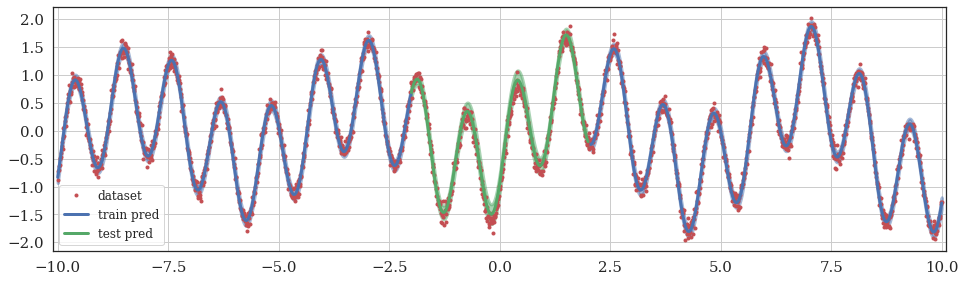

(array(0.123), array(-0.6888))

In [14]:
with torch.no_grad():
    pred_train_mu_l, pred_train_var_l = model._predict_exact(inputs_new=x_train_l)
    pred_train_mu_r, pred_train_var_r = model._predict_exact(inputs_new=x_train_r)
    
    pred_test_mu, pred_test_var = model._predict_exact(inputs_new = x_test, diag=True)    
    

plt.figure(figsize=(16,4.5))
plt.plot(x_train_l.cpu().data.numpy(),y_train_l.cpu().data.numpy(),'r.',label = 'dataset')    
plt.plot(x_train_l.cpu().data.numpy(),pred_train_mu_l.cpu().data.numpy(),'b',linewidth = 3,label = 'train pred')
plt.fill_between( x_train_l.cpu().data.numpy().squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  pred_train_mu_l.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_l.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)

plt.plot(x_train_r.cpu().data.numpy(),y_train_r.cpu().data.numpy(),'r.')    
plt.plot(x_train_r.cpu().data.numpy(),pred_train_mu_r.cpu().data.numpy(),'b',linewidth = 3)
plt.fill_between( x_train_r.cpu().data.numpy().squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  pred_train_mu_r.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var_r.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'b', facecolor = 'b',linewidth = 3)


plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'g',linewidth = 3,label = 'test pred')
plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                  alpha = 0.5, edgecolor = 'g', facecolor = 'g',linewidth = 3)


plt.xlim([-10-.1,10+.1])    
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

_evaluate_metric(pred_train_mu, pred_train_var, y_train)
_evaluate_metric(pred_test_mu, pred_test_var, y_test)    
